In [ ]:
#라이브러리 및 드라이브 연결
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.dataloader import Dataset, DataLoader
from google.colab import drive
drive.mount('/content/drive')
import os
import glob
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
import random
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#파라미터 선언
n1, n2 = 64, 32
f1, f2, f3 = 9, 1, 5
upscale_factor = 2
input_size = 33
output_size = input_size - f1 - f2 - f3 + 3
stride = 14
batch_size = 16
epochs = 1000
path = "/content/drive/MyDrive/Colab Notebooks/T91"
save_path = "/content/drive/MyDrive/Colab Notebooks/SCALE2_SRCNN_1000EPOCHS"

#Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(f"Using device: {device}")
print(f"GPU 사용 가능 여부: {torch.cuda.is_available()}")
print(f"사용 중인 장치: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU 사용 가능 여부: True
사용 중인 장치: Tesla T4


In [ ]:
#저해상도와 고해상도 이미지 패치 사이의 관계 학습
#학습데이터 만들려면 1)HR->LR로 만드는 작업 과 2) 각 이미지 crop하여 mapping하는 작업 필요
class CustomDataset(Dataset):
    def __init__(self, img_paths, input_size, output_size, stride=14, upscale_factor=2):
        super(CustomDataset, self).__init__()
        self.img_paths = glob.glob(img_paths + '/' + '*.png')
        print(f"Loaded {len(self.img_paths)} images from path: {img_paths}")
        self.stride = stride
        self.upscale_factor = upscale_factor
        self.sub_lr_imgs = []
        self.sub_hr_imgs = []
        self.input_size = input_size
        self.output_size = output_size
        self.pad = (self.input_size - self.output_size)//2
        #입력 데이터(LR)와 이에 대응되는 정답 데이터(HR)를 비교하여 손실(loss)를 계산해야하는데, 그러기위해선 둘의 크기가 동일해야한다
        #그래서 self.pad를 통해 학습 데이터셋 조정.

        #이미지 데이터 전처리
        for img_path in self.img_paths:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       # BGR -> RGB 변환

            # 고해상도 이미지 크기 조정: 이미지의 h, w 를 upscale_factor의 배수로 만들기 위해 단순 crop 방식(mod_crop) 사용
            h = img.shape[0] - (img.shape[0] % self.upscale_factor)
            w = img.shape[1] - (img.shape[1] % self.upscale_factor)
            img = img[:h, :w, :]

            # zoom_img(LR 이미지 생성)
            label = img.astype(np.float32) / 255.0
            temp_input = cv2.resize(label, dsize=(0, 0), fx=1/self.upscale_factor, fy=1/self.upscale_factor,
                         interpolation=cv2.INTER_AREA)
            input = cv2.resize(temp_input, dsize=(0, 0), fx=self.upscale_factor, fy=self.upscale_factor,
                    interpolation=cv2.INTER_CUBIC)

            # 5) Y 채널 추출 함수
            #    (float32 [0,1] 상태에서 YCbCr 변환 위해 0~255로 잠시 스케일링)
            def extract_y_channel(rgb_float):
                # (H,W,3) float32 [0,1] -> uint8 [0,255]
                rgb_255 = (rgb_float * 255.0).clip(0, 255).astype(np.uint8)
                ycbcr = cv2.cvtColor(rgb_255, cv2.COLOR_RGB2YCrCb)
                # ycbcr[...,0] => Y 채널 (uint8 [0..255])
                y_01 = ycbcr[..., 0].astype(np.float32) / 255.0
                # 최종 shape: (H,W), float32, [0..1]
                return y_01

            # 6) LR / HR 각각 Y 채널 추출
            input_y = extract_y_channel(input)
            label_y = extract_y_channel(label)

            # 7) sub-patch 크롭
            #    (0, input.shape[0]-input_size+1, stride)로 슬라이딩
            for hh in range(0, input_y.shape[0] - self.input_size + 1, self.stride):
                for ww in range(0, input_y.shape[1] - self.input_size + 1, self.stride):
                    # LR 패치
                    sub_lr_img = input_y[hh:hh + self.input_size, ww:ww + self.input_size]
                    # HR 패치!
                    sub_hr_img = label_y[hh + self.pad : hh + self.pad + self.output_size, ww + self.pad : ww + self.pad + self.output_size]
                    # (H,W) -> (1,H,W) PyTorch: 채널 차원 추가
                    sub_lr_img = np.expand_dims(sub_lr_img, axis=0)  # shape: (1, input_size, input_size)
                    sub_hr_img = np.expand_dims(sub_hr_img, axis=0)  # shape: (1, output_size, output_size)

                    self.sub_lr_imgs.append(sub_lr_img)
                    self.sub_hr_imgs.append(sub_hr_img)

        # 리스트 -> ndarray
        self.sub_lr_imgs = np.asarray(self.sub_lr_imgs, dtype=np.float32)
        self.sub_hr_imgs = np.asarray(self.sub_hr_imgs, dtype=np.float32)

    #PyTorch의 데이터셋 클래스(torch.utils.data.Dataset)를 상속받아 사용자 정의 데이터셋을 구현
    def __len__(self): #데이터셋의 전체 샘플 개수를 반환 -> DataLoader가 몇 개의 배치를 생성해야 할지 결정
        return len(self.sub_lr_imgs)
    def __getitem__(self, idx):   #데이터셋에서 특정 인덱스(idx)에 해당하는 데이터 샘플을 반환-->미니배치(batch) 데이터를 만든다.
        lr_img = self.sub_lr_imgs[idx]
        hr_img = self.sub_hr_imgs[idx]
        return lr_img, hr_img

In [ ]:
# 데이터셋 생성
train_dataset = CustomDataset(img_paths=path, input_size=input_size, output_size=output_size, stride=stride, upscale_factor=upscale_factor)
# DataLoader 생성
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 데이터셋 크기 확인
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: {train_dataloader.batch_size}")
print(f"Number of batches in dataloader: {len(train_dataloader)}")

Loaded 91 images from path: /content/drive/MyDrive/Colab Notebooks/T91
Dataset size: 21910
Batch size: 16
Number of batches in dataloader: 1370


In [ ]:
#test dataset 설정 part
from PIL import Image
import torchvision.transforms as transforms

class TestImageDataset(Dataset):
    def __init__(self, img_dir, upscale_factor=2, transform=None):
        """
        img_dir: 테스트 이미지들이 들어 있는 폴더 경로
        upscale_factor: SR 모델의 업스케일 배율

        """
        self.img_dir = img_dir
        self.upscale_factor = upscale_factor
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def rgb_to_y(self, img_rgb):
        """
        PIL 이미지(RGB)를 받아서 YCbCr 변환 후, Y 채널을 추출.
        반환: (1, H, W) 형태의 np.float32, [0,1] 범위 (Y 채널)
        """
        # PIL 이미지를 NumPy 배열로 변환 (RGB)
        img_np = np.array(img_rgb)
        # RGB -> YCbCr 변환 (OpenCV 사용)
        img_ycbcr = cv2.cvtColor(img_np, cv2.COLOR_RGB2YCrCb)
        # Y 채널 추출 (uint8)
        Y = img_ycbcr[:, :, 0]
        # float32 변환 및 [0,1] 정규화
        Y = Y.astype(np.float32) / 255.0
        # (H, W) -> (1, H, W)
        Y = np.expand_dims(Y, axis=0)
        return Y

    def __getitem__(self, idx):
        # 1) 이미지 경로
        img_path = self.img_paths[idx]
        # 2) 이미지 로드
        hr_img = Image.open(img_path).convert("RGB")
        hr_width, hr_height = hr_img.size  # PIL: (width, height)
        new_width = hr_width - (hr_width % self.upscale_factor)   # HR 너비를 upscale_factor 배수로 맞춤
        new_height = hr_height - (hr_height % self.upscale_factor)  # HR 높이를 upscale_factor 배수로 맞춤
        hr_img = hr_img.crop((0, 0, new_width, new_height))         # crop을 통해 크기 조정
        # 2) HR 이미지의 Y 채널 추출
        hr_y = self.rgb_to_y(hr_img)  # shape: (1, H, W)
        # 3) LR 이미지 생성: 논문과 동일하게 '다운샘플링 없이' HR을 곧바로 Bicubic 업스케일만 사용
        hr_width, hr_height = hr_img.size  # PIL: (width, height)
        lr_size = (hr_width // self.upscale_factor, hr_height // self.upscale_factor)
        # 다운샘플: Pillow BICUBIC
        lr_img = hr_img.resize(lr_size, resample=Image.BICUBIC)
        # 업샘플: 원본 크기로 복원
        lr_img = lr_img.resize((hr_width, hr_height), resample=Image.BICUBIC)

        # 4) LR 이미지의 Y 채널 추출
        lr_y = self.rgb_to_y(lr_img)  # shape: (1, H, W)

        # 5) 추가 transform이 있으면 적용 (여기서는 이미 Y 채널 변환 완료)
        if self.transform:
            hr_y = self.transform(hr_y)
            lr_y = self.transform(lr_y)

        return hr_y, lr_y


# ------------------------------------------------
# 테스트 데이터셋/로더 생성
# ------------------------------------------------
hr_img_path = "/content/drive/MyDrive/Colab Notebooks/Set 5"

test_dataset = TestImageDataset(hr_img_path,upscale_factor=2, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ------------------------------------------------
# 데이터셋 크기 확인
# ------------------------------------------------
print(f"테스트 이미지 개수: {len(test_dataset)}")

# ------------------------------------------------
# 배치 순회 예시
# ------------------------------------------------
for i, (hr_img, lr_img) in enumerate(test_dataloader, start=1):
    print(f"[Batch {i}] HR Y 텐서 크기: {hr_img.shape}, LR Y 텐서 크기: {lr_img.shape}")
    # 필요 시 break로 일부만 확인
    if i >= 5:
        break

테스트 이미지 개수: 5
[Batch 1] HR Y 텐서 크기: torch.Size([1, 1, 512, 512]), LR Y 텐서 크기: torch.Size([1, 1, 512, 512])
[Batch 2] HR Y 텐서 크기: torch.Size([1, 1, 288, 288]), LR Y 텐서 크기: torch.Size([1, 1, 288, 288])
[Batch 3] HR Y 텐서 크기: torch.Size([1, 1, 256, 256]), LR Y 텐서 크기: torch.Size([1, 1, 256, 256])
[Batch 4] HR Y 텐서 크기: torch.Size([1, 1, 280, 280]), LR Y 텐서 크기: torch.Size([1, 1, 280, 280])
[Batch 5] HR Y 텐서 크기: torch.Size([1, 1, 344, 228]), LR Y 텐서 크기: torch.Size([1, 1, 344, 228])


Original image shape (BGR): (197, 395, 3)
Mod cropped image shape (BGR): (196, 394, 3)
Extracted Y channel shape: (196, 394)


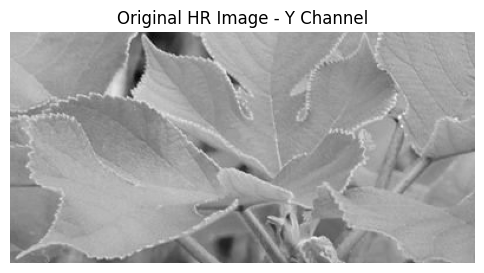

In [ ]:
# 원본 HR이미지 확인
img_path = train_dataset.img_paths[14]
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
print("Original image shape (BGR):", img.shape)

# Upscale factor에 맞게 mod crop 수행
upscale_factor = 2
h, w, _ = img.shape
h_mod = h - (h % upscale_factor)
w_mod = w - (w % upscale_factor)
img_cropped = img[:h_mod, :w_mod, :]
print("Mod cropped image shape (BGR):", img_cropped.shape)

# BGR 이미지를 YCbCr로 변환하고 Y 채널만 추출
img_ycbcr = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2YCrCb)
Y = img_ycbcr[:, :, 0]
print("Extracted Y channel shape:", Y.shape)

# Y 채널을 흑백으로 표시
plt.figure(figsize=(6, 6))
plt.imshow(Y, cmap='gray')
plt.title("Original HR Image - Y Channel")
plt.axis("off")
plt.show()


전체 인덱스 범위: 0 ~ 21909
index number: 16316


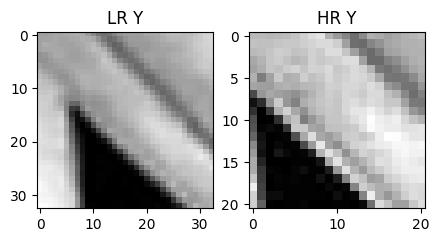

In [ ]:
# (저해상도, 고해상도) Paired 이미지 패치 확인 (Y 채널, 흑백)
if len(train_dataset.sub_lr_imgs) > 0:  # 데이터 존재 여부 확인
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))  # 한 행에 2개 서브플롯 생성 (각각 LR, HR)
    idx = random.randint(0, len(train_dataset.sub_lr_imgs) - 1)  # 랜덤 인덱스 선택
    num_samples = len(train_dataset.sub_lr_imgs)
    print(f"전체 인덱스 범위: 0 ~ {num_samples - 1}")

    # 반환된 patch들은 (1, H, W) 형태이므로, squeeze()로 (H, W)로 변환하여 흑백으로 시각화
    lr_patch = train_dataset.sub_lr_imgs[idx].squeeze(0)
    hr_patch = train_dataset.sub_hr_imgs[idx].squeeze(0)

    axes[0].imshow(lr_patch, cmap='gray')  # 첫 번째 서브플롯: LR Y 채널 patch
    axes[1].imshow(hr_patch, cmap='gray')  # 두 번째 서브플롯: HR Y 채널 patch
    print("index number:", idx)
    axes[0].set_title('LR Y')
    axes[1].set_title('HR Y')
    plt.show()
else:
    print("No images available for visualization!")


In [ ]:
# Model 선언
class SRCNN(nn.Module):
    def __init__(self, kernel_list, filters_list, num_channels=1):  # num_channels를 1로 변경 (Y 채널)
        super(SRCNN, self).__init__()

        f1, f2, f3 = kernel_list
        n1, n2 = filters_list

        # 모델 계층 정의
        self.conv1 = nn.Conv2d(num_channels, n1, kernel_size=f1, padding=0)
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=f2, padding=0)
        self.conv3 = nn.Conv2d(n2, num_channels, kernel_size=f3, padding=0)
        self.relu = nn.ReLU(inplace=True)

        # 모든 nn.Conv2d 모듈을 순회하여 He 초기화 방식(변형)을 적용.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
              # He 초기화 (Kaiming normal)
              nn.init.kaiming_normal_(
                  m.weight,
                  mode='fan_in',
                  nonlinearity='relu'
              )
              if m.bias is not None:
                nn.init.zeros_(m.bias)

        print(f"Conv3 output channels: {self.conv3.out_channels}")

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.clamp(x, 0.0, 1.0)
        return x


In [ ]:
#psnr설정
def get_psnr(label, output,boundary=0, min_value=0, max_value=1.0):
    """
    PSNR (Peak Signal-to-Noise Ratio) 계산 함수 (Y 채널 기준)

    Args:
        label (torch.Tensor 또는 np.ndarray): 원본 이미지 (Ground Truth) 정규화됨 0~1
        output (torch.Tensor 또는 np.ndarray): 복원된 이미지 (SRCNN 결과)
        boundary (int): 이미지 테두리를 잘라낼 크기 (기본값: 0)
        min_value (float): 최소 픽셀 값 범위 (기본값: 0)
        max_value (float): 최대 픽셀 값 범위 (기본값: 1.0)

    Returns:
        float: Y 채널의 평균 PSNR 값 (정수 값으로 반환)
    """
    # Y 채널 추출: 만약 입력이 RGB (3채널)이면, 아래 공식으로 Y 채널 계산
    if isinstance(label, torch.Tensor):
        if label.shape[0] == 3:
            # RGB -> Y: 0.299R + 0.587G + 0.114B, 결과 shape: (H, W)
            label = 0.299 * label[0] + 0.587 * label[1] + 0.114 * label[2]
            output = 0.299 * output[0] + 0.587 * output[1] + 0.114 * output[2]
    else:
        if label.shape[0] == 3:
            label = 0.299 * label[0, :, :] + 0.587 * label[1, :, :] + 0.114 * label[2, :, :]
            output = 0.299 * output[0, :, :] + 0.587 * output[1, :, :] + 0.114 * output[2, :, :]

    #테두리 크롭
    if boundary > 0:
        # (A) label, output이 torch.Tensor인지 np.ndarray인지 먼저 확인
        if isinstance(label, torch.Tensor):
            # 텐서의 shape이 [C, H, W] 형태라고 가정
            label = label[boundary:-boundary, boundary:-boundary]
            output = output[boundary:-boundary, boundary:-boundary]
        else:
            # NumPy 배열의 shape이 [C, H, W] 형태라고 가정
            label = label[boundary:-boundary, boundary:-boundary]
            output = output[boundary:-boundary, boundary:-boundary]

    # 입력 크기 검증
    assert label.shape == output.shape, "Error: Input images must have the same dimensions."

    #MSE 계산 (Y 채널)
    if isinstance(label, torch.Tensor):
        mse = torch.mean((label - torch.clamp(output, min_value, max_value)) ** 2)
        mse = mse.detach().cpu().numpy()  # NumPy 변환
    else:
        mse = np.mean((label - output) ** 2)  # NumPy 배열 처리

    # 픽셀 값 범위 설정
    PIXEL_MAX = 255.0 if max_value > 1.0 else 1.0  # 0~255 정규화된 경우 255, 0~1 정규화된 경우 1.0
    # PSNR 공식 적용 (각 채널별 계산 후 평균)
    psnr = 10 * np.log10((PIXEL_MAX ** 2) / (mse + 1e-10))  # log10 계산 시 0 방지

    return psnr

In [ ]:
# Train & Test loop
def train(dataloader, model, loss_fn, optimizer,device,epochs):
  global train_losses, train_psnrs  # 전역 변수로 설정 ,저장할 리스트도 추가
  model.train()
  running_loss = 0.0
  running_psnr = 0.0
  num_batches = len(dataloader)

  for batch_idx, (X, y) in enumerate(dataloader,start=1):
    #dataloader는 데이터를 미니배치로 분리하여 제공
    #데이터이동
    X = X.to(device)
    y = y.to(device)

    #예측 및 손실 계산
    pred = model(X)
    # 2) valid 영역 크기(pad) 계산 & 중앙 크롭 타깃
    pad = (y.size(-1) - pred.size(-1)) // 2        # =6
    if pad > 0:
      y_crop = y[..., pad:-pad, pad:-pad]        # [B,1,21,21]
    else:
      y_crop = y                                 # (패딩 없을 땐 full)

    # 3) 손실 계산 (predict vs cropped target)
    loss = loss_fn(pred, y_crop)

    #역전파
    optimizer.zero_grad() #이전 미니배치에서 계산된 기울기(gradients)를 초기화
    loss.backward() #손실 값에 대해 모델의 각 파라미터(가중치, 편향)의 기울기를 계산
    optimizer.step() #계산된 기울기를 사용하여 모델의 파라미터를 업데이트

    # PSNR 계산 (같은 y_crop 사용)
    with torch.no_grad():
            pred_clamped = torch.clamp(pred, 0.0, 1.0)
            mse = torch.mean((y_crop - pred_clamped) ** 2)
            psnr_value = 10.0 * torch.log10(1.0 / (mse + 1e-10))

    running_loss += loss.item()  # 손실 누적
    running_psnr += psnr_value.item()  # PSNR 값 누적

  # Epoch별 평균
  avg_loss = running_loss / num_batches
  avg_psnr = running_psnr / num_batches
  train_losses.append(avg_loss)
  train_psnrs.append(avg_psnr)
  print(f"Epoch Completed: Loss = {avg_loss:.6f} | PSNR = {avg_psnr} dB")
  return avg_loss, avg_psnr  #손실과 PSNR 반환

In [ ]:
# Model 선언 (단일 채널, Y 전용)
model = SRCNN(kernel_list=[f1, f2, f3],
              filters_list=[n1, n2],
              num_channels=1).to(device)
print(model)

# 손실 함수
loss_fn = nn.MSELoss()

# 논문 기반 학습률 설정/ Conv1, Conv2 레이어: 1e-4, Conv3 레이어: 1e-5
optimizer = optim.Adam(
    [
        {'params': model.conv1.parameters(), 'lr': 1e-4},
        {'params': model.conv2.parameters(), 'lr': 1e-4},
        {'params': model.conv3.parameters(), 'lr': 1e-5},
    ],

)


Conv3 output channels: 1
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU(inplace=True)
)


In [ ]:
# Model Training
train_losses = []
train_psnrs = []

for i in range(epochs):
  print(f"Epoch {i + 1} of {epochs}")
  model.train()
  if train_dataloader is None:
      raise ValueError("train_dataloader가 None입니다. 데이터 로더를 확인하세요.")

  train_loss, train_psnr = train(train_dataloader, model, loss_fn, optimizer,device,epochs)

print("Done!")
torch.save(model.state_dict(), save_path)

Epoch 1 of 1000
Epoch Completed: Loss = 0.020327 | PSNR = 24.103330801177197 dB
Epoch 2 of 1000
Epoch Completed: Loss = 0.001652 | PSNR = 28.15419951390176 dB
Epoch 3 of 1000
Epoch Completed: Loss = 0.001358 | PSNR = 28.99785529923265 dB
Epoch 4 of 1000
Epoch Completed: Loss = 0.001229 | PSNR = 29.46623587086253 dB
Epoch 5 of 1000
Epoch Completed: Loss = 0.001166 | PSNR = 29.7236698053179 dB
Epoch 6 of 1000
Epoch Completed: Loss = 0.001134 | PSNR = 29.816784940844904 dB
Epoch 7 of 1000
Epoch Completed: Loss = 0.001116 | PSNR = 29.883509201551007 dB
Epoch 8 of 1000
Epoch Completed: Loss = 0.001103 | PSNR = 29.94577598711 dB
Epoch 9 of 1000
Epoch Completed: Loss = 0.001093 | PSNR = 29.9821276560317 dB
Epoch 10 of 1000
Epoch Completed: Loss = 0.001084 | PSNR = 30.02975553665718 dB
Epoch 11 of 1000
Epoch Completed: Loss = 0.001077 | PSNR = 30.052806780460106 dB
Epoch 12 of 1000
Epoch Completed: Loss = 0.001070 | PSNR = 30.06974256752181 dB
Epoch 13 of 1000
Epoch Completed: Loss = 0.001064 

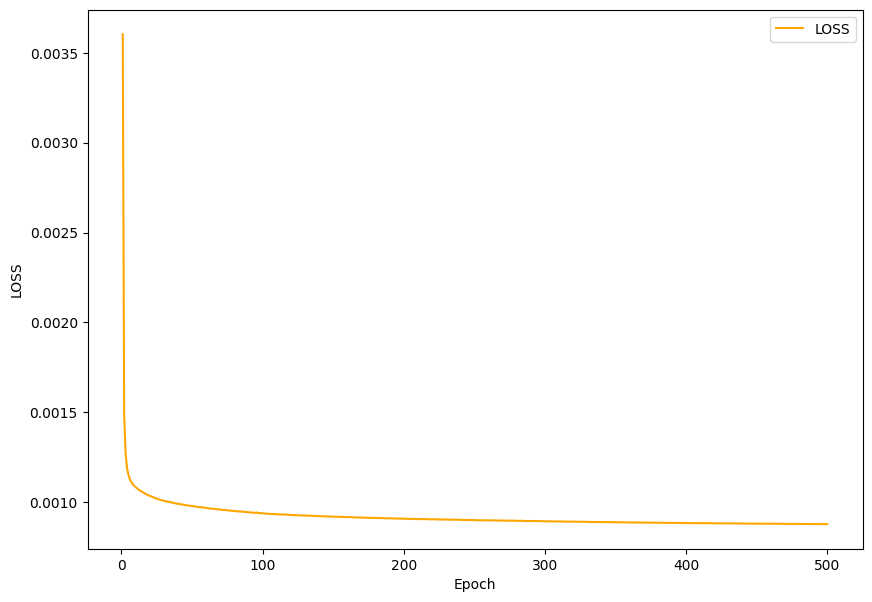

In [ ]:
# loss plots
if not train_losses:
    print("Error: train_losses empty")

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_losses)+1), train_losses, color='orange', label='LOSS')
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.show()

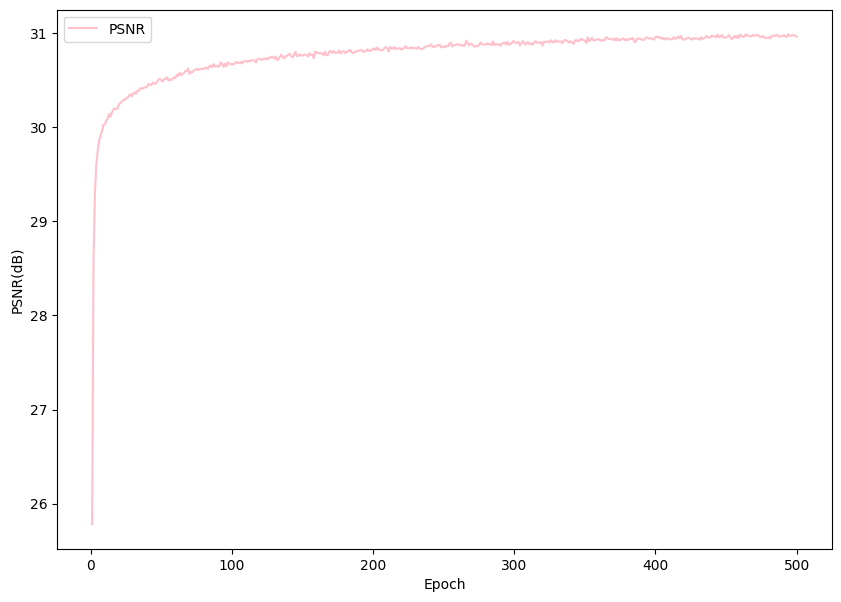

In [ ]:
# PSNR plots
if not train_psnrs:
    print("Error: train_psnrs empty")

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_psnrs)+1), train_psnrs, color='pink', label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR(dB)')
plt.legend()
plt.show()

Image bird.png loaded successfully: (288, 288, 3)


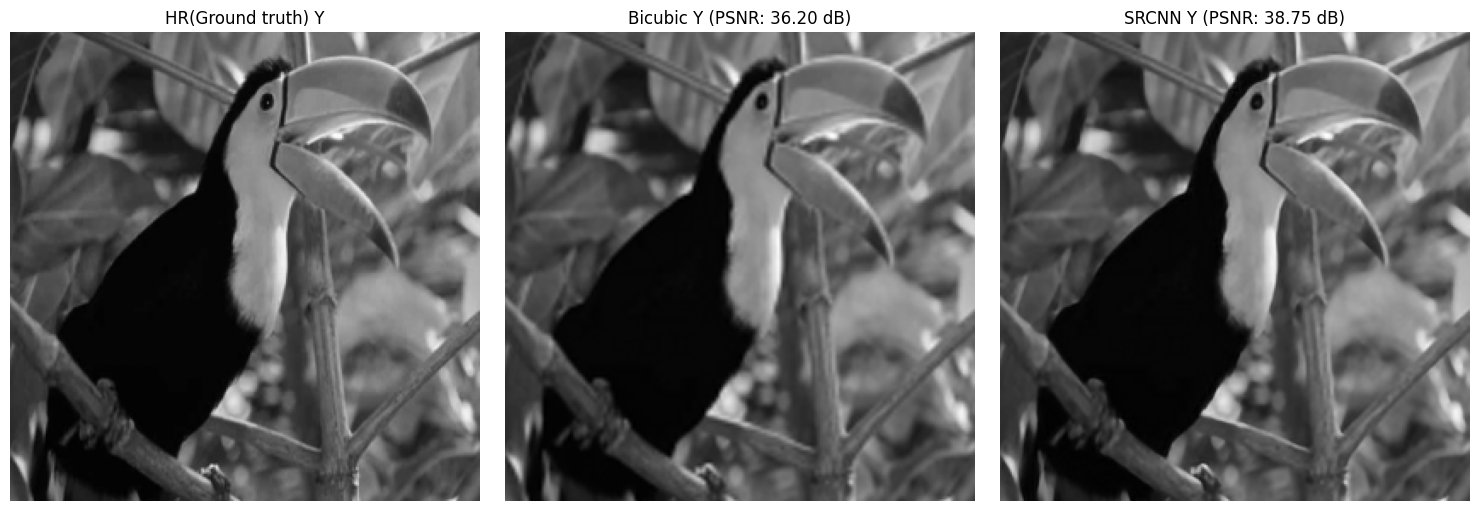

HR(Ground truth) Y Range: min=0.003921568859368563, max=0.9647058844566345
Bicubic Y Range: min=0.0, max=0.9647058844566345
SRCNN Y Range: min=0.0, max=0.9600369930267334
HR(Ground truth) Y dtype: float32


In [ ]:
import os
import cv2
import glob
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- 1. 이미지 변환 관련 함수들 ---
upscale_factor=2
# PSNR 계산 함수
def calculate_psnr(img1, img2, max_val=1.0):
    mse = np.mean((img1 - img2) ** 2)
    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-10))
    return psnr

# 중앙 crop 함수
def center_crop(img, height, width):
    h, w = img.shape[:2]
    start_h = (h - height) // 2
    start_w = (w - width) // 2
    if img.ndim == 3:
        return img[start_h:start_h + height, start_w:start_w + width, :]
    else:
        return img[start_h:start_h + height, start_w:start_w + width]

# RGB -> Y 채널 변환 함수 (입력: float32, [0,1], shape: (H, W, 3); 반환: (H, W) float32, [0,1])
def rgb_to_y(img_rgb):
    # 먼저 0~1 float32 이미지를 0~255 uint8로 변환
    img_uint8 = np.clip(img_rgb * 255.0, 0, 255).astype(np.uint8)
    # YCbCr 변환 (OpenCV 사용)
    img_ycbcr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2YCrCb)
    Y = img_ycbcr[:, :, 0].astype(np.float32) / 255.0
    return Y

# --- 2. 테스트 이미지 로드 및 전처리 ---

hr_img_path = '/content/drive/MyDrive/Colab Notebooks/Set 5'

if not os.path.exists(hr_img_path):
    print(f"Error: Folder not found at {hr_img_path}")
    exit()

# 디렉토리 내 모든 이미지 파일 가져오기
img_files = [f for f in os.listdir(hr_img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if len(img_files) == 0:
    print("Error: No image files found in the directory.")
    exit()

# 랜덤으로 하나의 이미지 선택
img_file = random.choice(img_files)
img_path = os.path.join(hr_img_path, img_file)
hr_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
if hr_img is None:
    print(f"Error: Image {img_file} cannot be read. Check the file format.")
    exit()

# BGR -> RGB 변환
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print(f"Image {img_file} loaded successfully: {hr_img.shape}")

# 정규화 및 float32 변환 (0~1)
hr_img = hr_img.astype(np.float32) / 255.0

# 고해상도 이미지 크기 조정:  단순 crop (mod_crop) 사용
h, w, _ = hr_img.shape
h_new = h - (h % upscale_factor)
w_new = w - (w % upscale_factor)
hr_img_cropped = hr_img[:h_new, :w_new, :]
# --- 3. Bicubic 보간법으로 LR 이미지 생성 및 Y 채널 변환 ---

# LR 이미지 생성: 다운샘플( INTER_AREA ) 후 업샘플( INTER_CUBIC )
temp_img = cv2.resize(hr_img_cropped, dsize=(0, 0), fx=1/upscale_factor, fy=1/upscale_factor, interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, dsize=(0, 0), fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
bicubic_img = np.clip(bicubic_img, 0.0, 1.0)

# HR 및 Bicubic 이미지를 Y 채널로 변환
hr_y = rgb_to_y(hr_img_cropped)
bicubic_y = rgb_to_y(bicubic_img)

# --- 4. SRCNN 모델 추론을 통한 결과 생성 ---

# 모델 입력 준비:Bicubic Y 채널 사용
# 모델 입력: bicubic_y (H, W) -> (1, H, W) -> (1, 1, H, W)
input_y = np.expand_dims(bicubic_y, axis=0)   # (1, H, W)
input_tensor = torch.tensor(input_y).unsqueeze(0).to(device)

# 모델 가중치 불러오기 및 평가 모드 설정
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    output_tensor = model(input_tensor)
# 모델 출력: (B, 1, H, W) -> (H, W, 1) -> (H, W)
srcnn_y = output_tensor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
srcnn_y = np.clip(srcnn_y, 0.0, 1.0)
# srcnn_y의 shape가 (H, W, 1)라면 squeeze 마지막 차원
if srcnn_y.ndim == 3 and srcnn_y.shape[2] == 1:
    srcnn_y = np.squeeze(srcnn_y, axis=2)

# --- 5. 중앙 Crop (Y 채널) ---
# 모든 이미지 (hr_y, bicubic_y, srcnn_y)는 (H, W)
min_h = min(hr_y.shape[0], bicubic_y.shape[0], srcnn_y.shape[0])
min_w = min(hr_y.shape[1], bicubic_y.shape[1], srcnn_y.shape[1])
hr_y_cropped = center_crop(np.expand_dims(hr_y, axis=-1), min_h, min_w).squeeze(-1)
bicubic_y_cropped = center_crop(np.expand_dims(bicubic_y, axis=-1), min_h, min_w).squeeze(-1)
srcnn_y_cropped = center_crop(np.expand_dims(srcnn_y, axis=-1), min_h, min_w).squeeze(-1)

# --- 6. PSNR 계산 ---
psnr_bicubic = calculate_psnr(hr_y_cropped, bicubic_y_cropped)
psnr_srcnn = calculate_psnr(hr_y_cropped, srcnn_y_cropped)

# --- 7. 시각화 (흑백, Y 채널) ---
if srcnn_y is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(hr_y_cropped, cmap='gray')
    axes[0].set_title("HR(Ground truth) Y")
    axes[1].imshow(bicubic_y_cropped, cmap='gray')
    axes[1].set_title(f"Bicubic Y (PSNR: {psnr_bicubic:.2f} dB)")
    axes[2].imshow(srcnn_y_cropped, cmap='gray')
    axes[2].set_title(f"SRCNN Y (PSNR: {psnr_srcnn:.2f} dB)")
else:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(hr_y_cropped, cmap='gray')
    axes[0].set_title("HR(Ground truth) Y")
    axes[1].imshow(bicubic_y_cropped, cmap='gray')
    axes[1].set_title(f"Bicubic Y (PSNR: {psnr_bicubic:.2f} dB)")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

# --- 8. 이미지 범위 및 dtype 확인 ---
print(f"HR(Ground truth) Y Range: min={hr_y_cropped.min()}, max={hr_y_cropped.max()}")
print(f"Bicubic Y Range: min={bicubic_y_cropped.min()}, max={bicubic_y_cropped.max()}")
if srcnn_y is not None:
    print(f"SRCNN Y Range: min={srcnn_y_cropped.min()}, max={srcnn_y_cropped.max()}")
print(f"HR(Ground truth) Y dtype: {hr_y_cropped.dtype}")


In [ ]:
# ------------------------------
# 4. 폴더 내 모든 Test 이미지 평균 PSNR
# ------------------------------
psnr_bicubic_list = []
psnr_srcnn_list = []
upscale_factor=2
for f in img_files:
    img_path = os.path.join(hr_img_path, f)
    hr_img_all = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if hr_img_all is None:
        print(f"Error reading {f}, skip.")
        continue
    hr_img_all = cv2.cvtColor(hr_img_all, cv2.COLOR_BGR2RGB)
    hr_img_all = hr_img_all.astype(np.float32) / 255.0

    hh, ww, _ = hr_img_all.shape
    hh_mod = hh - (hh % upscale_factor)
    ww_mod = ww - (ww % upscale_factor)
    hr_img_all = hr_img_all[:hh_mod, :ww_mod, :]

    # Bicubic✅
    tmp_img_all = cv2.resize(hr_img_all, dsize=(0, 0),
                             fx=1.0/upscale_factor, fy=1.0/upscale_factor,
                             interpolation=cv2.INTER_AREA)
    bicubic_img_all = cv2.resize(tmp_img_all, dsize=(0, 0),
                                 fx=upscale_factor, fy=upscale_factor,
                                 interpolation=cv2.INTER_CUBIC)
    bicubic_img_all = np.clip(bicubic_img_all, 0.0, 1.0)

    # Y 채널
    hr_y_all = rgb_to_y(hr_img_all)
    bicubic_y_all = rgb_to_y(bicubic_img_all)

    # 모델 입력
    input_y_all = np.expand_dims(bicubic_y_all, axis=0)
    input_tensor_all  = torch.tensor(input_y_all).unsqueeze(0).to(device)
    with torch.no_grad():
        out_all = model(input_tensor_all)
    srcnn_y_all = out_all.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    srcnn_y_all = np.clip(srcnn_y_all, 0.0, 1.0)
    if srcnn_y_all.ndim == 3 and srcnn_y_all.shape[2] == 1:
        srcnn_y_all = srcnn_y_all.squeeze(-1)

    # 중앙 crop
    min_h_all = min(hr_y_all.shape[0], bicubic_y_all.shape[0], srcnn_y_all.shape[0])
    min_w_all = min(hr_y_all.shape[1], bicubic_y_all.shape[1], srcnn_y_all.shape[1])
    hr_y_all_cropped = center_crop(np.expand_dims(hr_y_all, -1), min_h_all, min_w_all).squeeze(-1)
    bicubic_y_all_cropped = center_crop(np.expand_dims(bicubic_y_all, -1), min_h_all, min_w_all).squeeze(-1)
    srcnn_y_all_cropped = center_crop(np.expand_dims(srcnn_y_all, -1), min_h_all, min_w_all).squeeze(-1)

    # PSNR
    psnr_bi = calculate_psnr(hr_y_all_cropped, bicubic_y_all_cropped)
    psnr_sr = calculate_psnr(hr_y_all_cropped, srcnn_y_all_cropped)

    psnr_bicubic_list.append(psnr_bi)
    psnr_srcnn_list.append(psnr_sr)

if len(psnr_bicubic_list) > 0:
    avg_bicubic = sum(psnr_bicubic_list) / len(psnr_bicubic_list)
    avg_srcnn = sum(psnr_srcnn_list) / len(psnr_srcnn_list)
    print(f"\n[Average PSNR on Test Images]")
    print(f"Bicubic: {avg_bicubic:.2f} dB, SRCNN: {avg_srcnn:.2f} dB")
else:
    print("No valid images to compute average PSNR.")


[Average PSNR on Test Images]
Bicubic: 32.79 dB, SRCNN: 34.57 dB
